In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
#!pip install pygam
from pygam import LinearGAM
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras import Input


In [5]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("country_data/ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151


In [6]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [7]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()

# set X equal to df_daily
X = df_daily

In [8]:
# create 24-hour t2m arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.t2m.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)

### Visualization of independent vars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5601ef0518>,
      dtype=object)

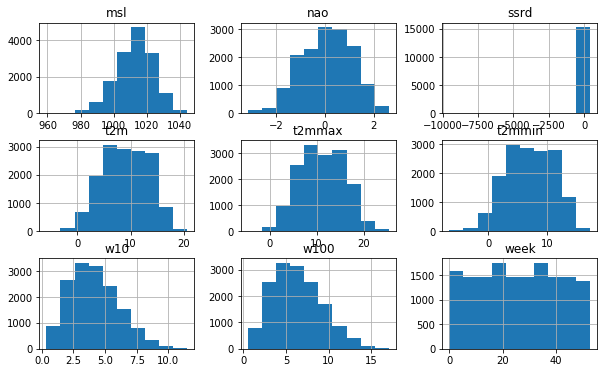

In [9]:
X.hist(figsize=(10,6))

Mostly normal distributions of variables of interest, except ssrd. 

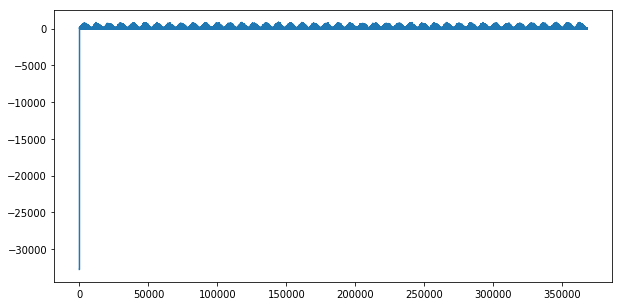

In [7]:
df.ssrd.plot(figsize=(10,5))

Remove outlier from ssrd.

/opt/jaspy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


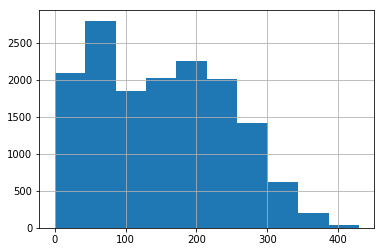

In [10]:
# remove outliers
X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
X.ssrd.hist()

Split train/test

In [9]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

### Modeling

Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [11]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)

print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)

R2-score:  0.9788673538277753
MAE-score:  0.4251066266580952


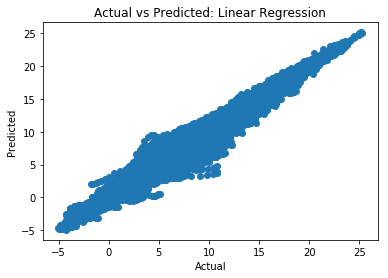

In [12]:
# plot results
plt.scatter(y_test.values.flatten(),pred_reg.flatten())
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Linear Regression")
plt.rcParams["figure.figsize"] = (20,5)

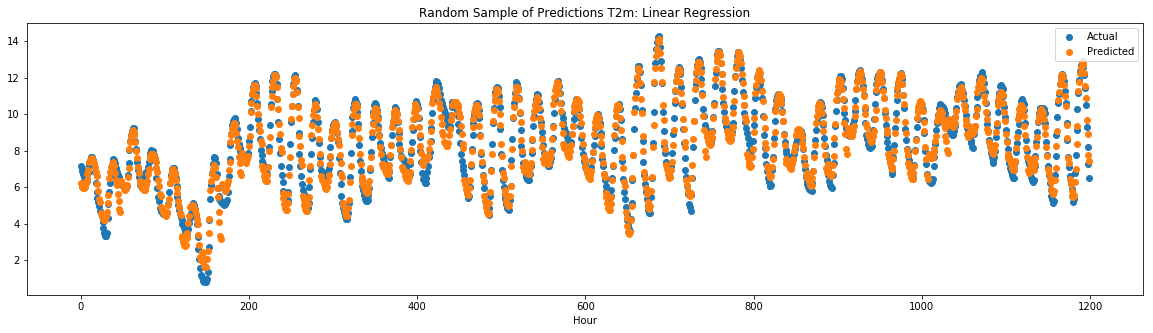

In [13]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_reg[300:350])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Linear Regression")
plt.legend(["Actual","Predicted"])

### Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [15]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)

R2-score:  0.9811268839282521
MAE-score:  0.38830485813982735


In [ ]:
n_estimators = []
mae = []
for i in range(1,100,10):
    rf = RandomForestRegressor(n_estimators=i).fit(X_train,y_train)
    pred_rf = rf.predict(X_test)
    n_estimators.append(i)
    mae.append(mean_absolute_error(y_test,pred_rf)) 
n_estimators = np.array(n_estimators)
mae = np.array(mae)

plt.plot(n_estimators,mse)
plt.title("Scree Plot: Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("MAE")

Maximum number of trees can be set to 100 as there is little computational cost.

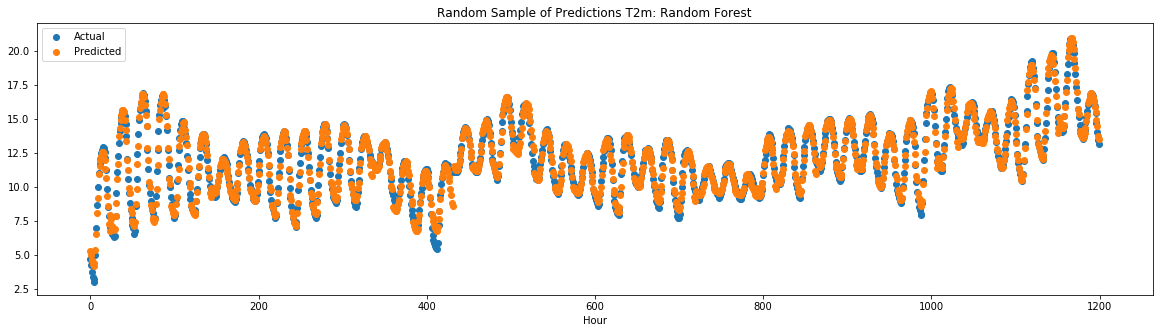

In [16]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_rf[4000:4050])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Random Forest")
plt.legend(["Actual","Predicted"])
plt.rcParams["figure.figsize"] = (20,5)

### Analyze Best Performer

The best performer was Random Forest. 

Below is a visual representation of the seasonal error.

Text(0, 0.5, 'MSE')

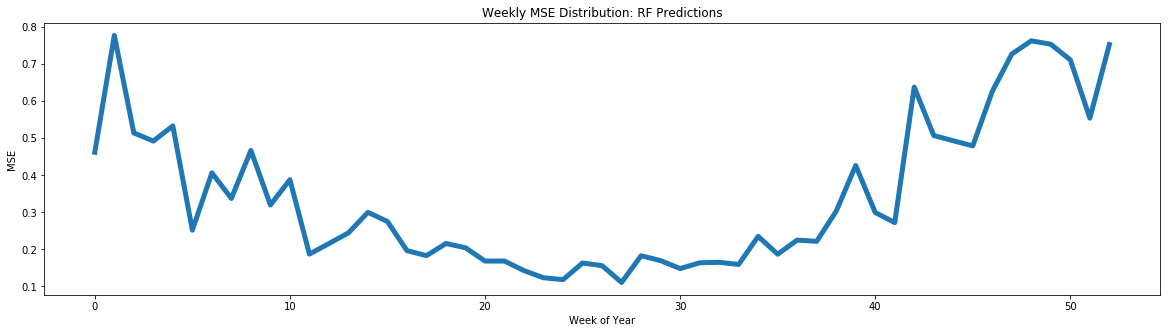

In [17]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_week = se.groupby(se.index.week).mean().mean(axis=1)
plt.plot(np.arange(0,53,1),mse_by_week.values.flatten(),linewidth=5)
plt.title("Weekly MSE Distribution: RF Predictions")
plt.xlabel("Week of Year")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

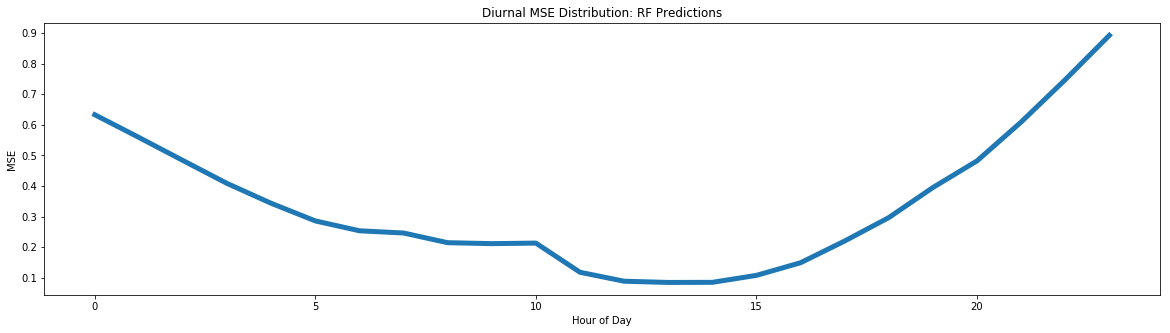

In [18]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_hour = se.groupby(se.index.hour).mean()
plt.plot(np.arange(0,24,1),mse_by_hour.values.flatten(),linewidth=5)
plt.title("Diurnal MSE Distribution: RF Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("MSE")

Found that winter weeks have higher MSE in comparison to summer months.

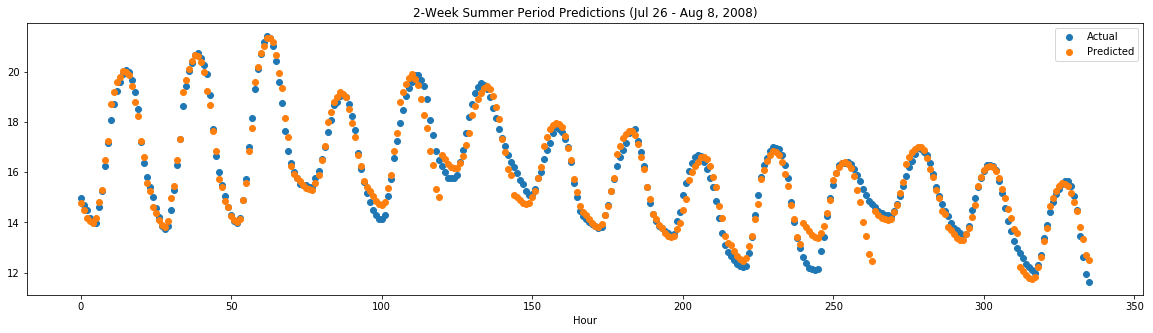

In [19]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_rf[60:74]
pred_d14_winter = pred_rf[230:244]

plt.scatter(np.arange(0,14*24,1),y_d14_summer)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Predicted"])

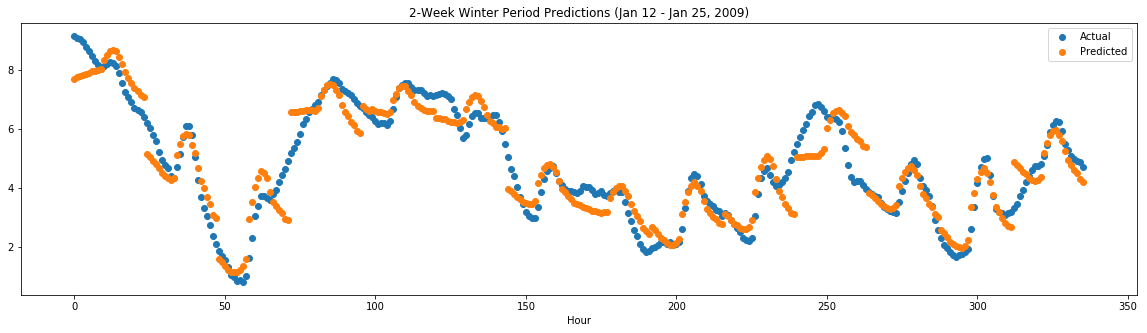

In [20]:
plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

Clearly the model has issues with the extreme fluctuations of temperatures across the UK in the winter months, with predictions unable to capture the variability of the diurnal cycle. Summer months exhibit a more constant diurnal cycle with much better predictions.

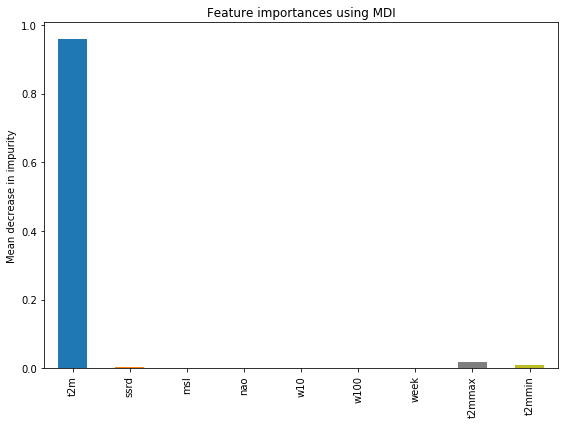

In [22]:
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


- Try lag of previous day (tmean,tmin) and next day (tmean,tmin)
- Feature importance
- Gradient previous day/next day

### Random Forest with Lag Variables

In [11]:
# add lag features
X["t2min_previous"] = X.t2mmin.shift(1)
X["t2m_previous"] = X.t2m.shift(1)
X["t2min_next"] = X.t2mmin.shift(-1)
X["t2m_next"] = X.t2m.shift(-1)
X = X.fillna(0)

Split train/test

In [12]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

In [130]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [131]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)

R2-score:  0.9883025615575917
MAE-score:  0.31412963235343344


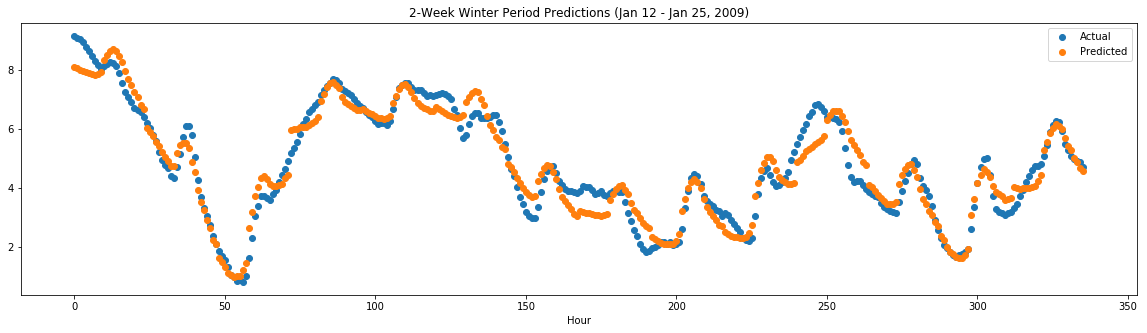

In [132]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_rf[60:74]
pred_d14_winter = pred_rf[230:244]


plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

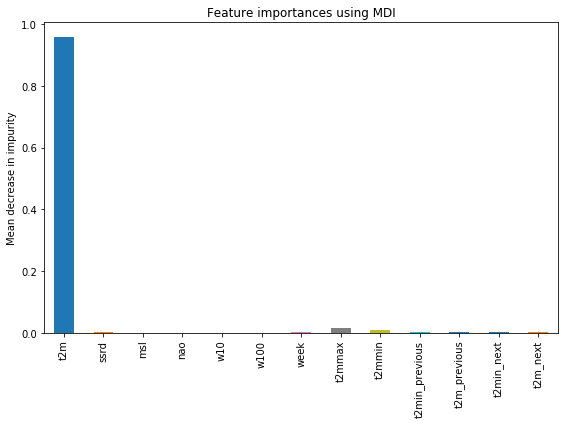

In [145]:
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Overall, adding the previous day inputs proved successful in slightly improving the model performance. 0z and 23z day temperatures are better connected than the previous model, especially during the winter months. In addition, MSL/NAO/w10/W100 are not beneficial parameters to the model.

### Case Studies

In [133]:
def RMS_based_eval(timeseries_for_eval,field,case_no,method_str):

    ''''
    timeseries_for_eval [array] must be the appropriate length for case study evaluation 
    Case1 = 168 hours
    Case2 = 216 hours
    Case3 = 672 hours
    field [str] must either be 'T2m', 'speed10m' , or 'rsds'
    case no [str] must be either 1,2 or 3.
    method_str [str] what you'd like it referred to as.
    '''
    
    obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
    
    obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')
    MAE = np.mean(obs - timeseries_for_eval)
    RMS = np.sqrt(np.nanmean((obs - timeseries_for_eval)**2))
    
    fig = plt.figure(figsize=(12,4))
    plt.plot(obs_date,obs,color='k',label='ERA5 obs')
    if field == 'T2m':
        plt.plot(obs_date,timeseries_for_eval,color='r',label=method_str)
        plt.ylabel('2m temperature ($^{o}$C)',fontsize=14)
        plt.title('Case study ' + case_no )
        plt.xlabel('MAE = ' + str(MAE) + ' , RMS = ' + str(RMS))
    if field == 'speed10m':
        plt.plot(obs_date,timeseries_for_eval,color='b',label=method_str)
        plt.ylabel('10m wind speed (ms$^{-1}$)',fontsize=14)
        plt.title('Case study ' + case_no)
    if field == 'rsds':
        plt.plot(obs_date,timeseries_for_eval,color='gold',label=method_str)
        plt.ylabel('Surface shortwave radiation (Wm$^{-2}$)',fontsize=14)
        plt.title('Case study ' + case_no )
    plt.legend(frameon=False)
    plt.show()
    return([MAE, RMS])

In [141]:
# index y_test to determine dates for case studies
days = pd.to_datetime(y_test.index)
index_case1 = np.where((days>=datetime(2019,11,18)) & (days<=datetime(2019,11,24)))
input_case1 = pred_rf[index_case1].flatten()

index_case2 = np.where((days>=datetime(2020,7,1)) & (days<=datetime(2020,7,9)))
input_case2 = pred_rf[index_case2].flatten()

index_case3 = np.where((days>=datetime(2018,2,20)) & (days<=datetime(2018,3,19)))
input_case3 = pred_rf[index_case3].flatten()

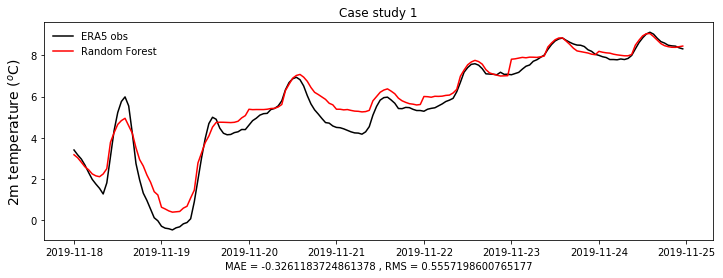

[-0.3261183724861378, 0.5557198600765177]

In [142]:
RMS_based_eval(input_case1,"T2m","1","Random Forest")

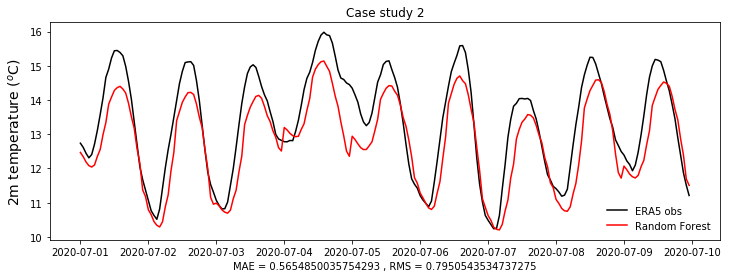

[0.5654850035754293, 0.7950543534737275]

In [143]:
RMS_based_eval(input_case2,"T2m","2","Random Forest")

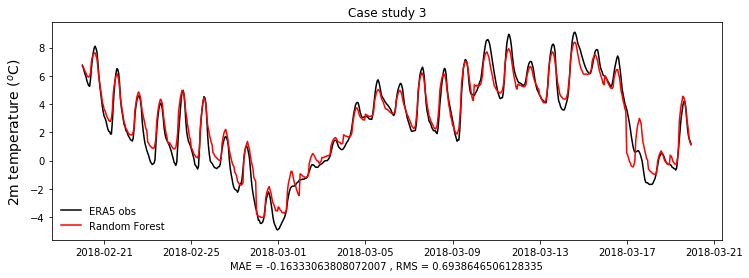

[-0.16333063808072007, 0.6938646506128335]

In [144]:
RMS_based_eval(input_case3,"T2m","3","Random Forest")

### Random Forest w/ precipitation & cloud cover 
- collect precipitation, cloud cover